In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline

This notebook uses all the raw data from the masterlist, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SERVS and SWIRE) I will split the XID+ run into two different runs. Here we use the SERVS depth.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_XMM-LSS/data/holes_XMM-LSS_irac1_O16_20180420_MOC.fits')

## Read in Masterlist
Next step is to read in Masterlist and select only sources that are detected in mid-infrared and at least one other wavelength domain (i.e. optical or nir). This will remove most of the objects in the catalogue that are artefacts. We can do this by using the `flag_optnir_det` flag and selecting sources that have a binary value of $>= 5$

In [3]:
from astropy.io import fits

masterlist=fits.open('../../dmu1/dmu1_ml_XMM-LSS/data/master_catalogue_xmm-lss_20180221_xidplus.fits')

In [4]:
good=masterlist[1].data['flag_optnir_det']>=5

In [5]:
masterlist[1].columns

ColDefs(
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'help_id'; format = '27A'
    name = 'flag_optnir_obs'; format = 'K'
    name = 'f_irac_i3'; format = 'D'
    name = 'ferr_irac_i3'; format = 'D'
    name = 'f_irac_i4'; format = 'D'
    name = 'ferr_irac_i4'; format = 'D'
    name = 'f_irac_i1'; format = 'D'
    name = 'ferr_irac_i1'; format = 'D'
    name = 'f_irac_i2'; format = 'D'
    name = 'ferr_irac_i2'; format = 'D'
    name = 'flag_optnir_det'; format = 'K'
)

### Create uninformative (i.e. conservative) upper and lower limits based on IRAC fluxes
As the default flux prior for XID+ is a uniform distribution, it makes sense to set reasonable upper and lower 24 micron flux limits based on the longest wavelength IRAC flux available. For a lower limit I take IRAC/500.0 and for upper limit I take IRACx500.

In [7]:
MIPS_lower=np.full(good.sum(),0.0)
MIPS_upper=np.full(good.sum(),1E5)

In [9]:
for i in range(0,good.sum()):
    if masterlist[1].data['f_irac_i4'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i4'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i4'][good][i]*500.0
    elif masterlist[1].data['f_irac_i3'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i3'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i3'][good][i]*500.0
    elif masterlist[1].data['f_irac_i2'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i2'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i2'][good][i]*500.0
    elif masterlist[1].data['f_irac_i1'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i1'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i1'][good][i]*500.0

In [6]:
npzfile = np.load('./tmp_mips_prior.npz')
MIPS_lower=npzfile['arr_0']
MIPS_upper=npzfile['arr_1']

In [7]:
MIPS_Map=fits.open('../../dmu17/dmu17_XMM-LSS/data/mips_help.fits.gz')

## Read in PSF

In [8]:
MIPS_psf=fits.open('../../dmu17/dmu17_XMM-LSS/dmu17_MIPS_XMM-LSS_SPUDS_20180515.fits')

In [9]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=10

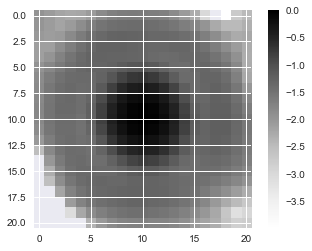

In [10]:
import pylab as plt
plt.imshow(np.log10(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/np.max(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1])))
plt.colorbar()

## Set XID+ prior class

In [14]:
prior_MIPS=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=Sel_func)
prior_MIPS.prior_cat(masterlist[1].data['ra'][good],masterlist[1].data['dec'][good],'master_catalogue_xmm-lss_20180221_xidplus',flux_lower=MIPS_lower,
                     flux_upper=MIPS_upper,ID=masterlist[1].data['help_id'][good])
prior_MIPS.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,21),np.arange(0,21))

keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]


## Calculate tiles
As fitting the whole map would be too computationally expensive, I split based on HEALPix pixels. For MIPS, the optimum order is 11. So that I don't have to read the master prior based on the whole map into memory each time (which requires a lot more memory) I also create another layer of HEALPix pixels based at the lower order of 7.

In [15]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
order_large=7
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder=''
outfile=output_folder+'Master_prior_SPUDS.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior_MIPS],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles_SPUDS.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 11927 tiles required for input catalogue and 65 large tiles


SystemExit: 

In [27]:
with open('Master_prior.pkl', 'wb') as f:
    pickle.dump({'priors':prior_MIPS,'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)

keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]


([<aplpy.core.FITSFigure at 0x18706a4e0>],
 <matplotlib.figure.Figure at 0x1154bd630>)

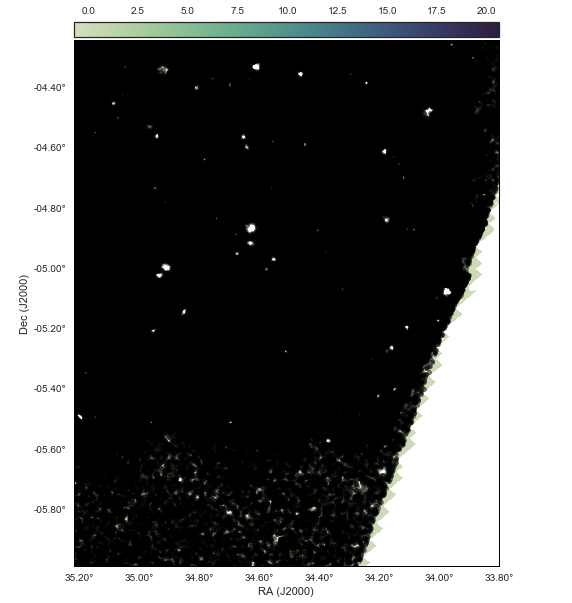

In [25]:
xidplus.plot_map([prior_MIPS])

## Cut down Master Prior to SPUDS
As the decision has now been made to use the SPUDS map where available, the Master prior needs to be cut down to the MOC representing SPUDS (created by Aladin)

In [16]:
diff_moc=pymoc.MOC()
diff_moc.read('./../../dmu17/dmu17_XMM-LSS/data/mips_help-1-_MOC.fits')

In [17]:
prior_MIPS.moc=diff_moc
prior_MIPS.cut_down_prior()

keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]


In [18]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
order_large=7
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder=''
outfile=output_folder+'Master_prior_SPUDS.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior_MIPS],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles_SPUDS.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 1728 tiles required for input catalogue and 15 large tiles


SystemExit: 

In [24]:
np.savez('./tmp_mips_prior', MIPS_lower, MIPS_upper)